# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [51]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [ ]:
df = pd.read_csv(trainingdatafolder+'trainingdata.csv', index_col=0)

In [459]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'random/'

featurefolder = 'ressummaryfeaturesxgbv6Norbits{0:.1f}Nout1000/'.format(Norbits)
trainingdatafolder = datapath+dset+featurefolder

In [460]:
df = pd.read_csv(trainingdatafolder+'trainingdata.csv', index_col=0)

In [462]:
df['EPstdnearN'] = df['EPstdnear']/df['EPmednear']
df['EMstdnearN'] = df['EMstdnear'] *df['EMcrossnear']/df['reshalfwidthnear']
df['EMstdfarN'] = df['EMstdfar'] *df['EMcrossfar']/df['reshalfwidthfar']
df['EMstdfarU'] = df['EMstdfar'] *df['EMcrossfar']
df['EMstdnearU'] = df['EMstdnear'] *df['EMcrossnear']
del df['unstableinNorbits']
df.to_csv(trainingdatafolder+'trainingdata.csv')

In [218]:
df.head()

,betanear,EMcrossnear,jnear,knear,strengthnear,C_AMDnear,reshalfwidthnear,betafar,EMcrossfar,jfar,...,EMrollingstdouter,EPmedouter,EPmaxouter,EPstdouter,EPslopeouter,EProllingstdouter,AMDerr,EPstdnearN,EMstdnearN,EMstdfarN
0,2.581870,0.060234,12.0,1.0,0.671084,27.354537,0.004034,19.828024,0.504063,-1.0,...,0.074180,0.008829,0.017873,0.004452,3.319493,0.024728,0.002315,0.006769,0.458982,NaN
1,3.102609,0.080547,9.0,1.0,0.335604,2.190450,0.003501,9.349653,0.240504,4.0,...,0.007272,0.062147,0.073939,0.006551,0.226235,0.006962,0.007039,0.013101,0.399550,NaN
2,4.072226,0.129660,6.0,1.0,1.182296,32.340940,0.007572,19.851676,1.001981,3.0,...,0.134447,0.009563,0.011429,0.001174,0.191314,0.002895,0.011763,0.021052,0.494307,0.062717
3,10.746532,0.406112,5.0,2.0,0.710219,0.949707,0.005442,15.024486,0.427768,5.0,...,0.001418,0.076324,0.078691,0.001448,2.226337,0.001141,0.004514,0.009424,2.843739,NaN
4,3.700114,0.059897,12.0,1.0,0.774914,5.847346,0.002636,7.123620,0.257596,7.0,...,0.027835,0.002708,0.003033,0.000196,1.788012,0.010568,0.016592,0.053703,0.564171,2.933028


In [220]:
df['reshalfwidthnear']

0       0.004034
1       0.003501
2       0.007572
3       0.005442
4       0.002636
5       0.001393
6       0.004977
7       0.001515
8       0.010639
9       0.003777
10      0.003506
11      0.004139
12           NaN
13      0.003456
14      0.001669
15      0.006143
16      0.000898
17      0.002784
18      0.010224
19      0.001967
20      0.002489
21      0.006451
22      0.009678
23      0.001157
24      0.006778
25      0.001617
26      0.013150
27           NaN
28      0.001222
29      0.004954
          ...   
9969    0.010553
9970    0.004521
9971         NaN
9972    0.001458
9973    0.003036
9974    0.002853
9975    0.014873
9976    0.001976
9977    0.002461
9978    0.009249
9979    0.000475
9980    0.005281
9981    0.008757
9982    0.003565
9983    0.001825
9984    0.002172
9985    0.008165
9986    0.000674
9987    0.000358
9988    0.001117
9989    0.003504
9990    0.000896
9991    0.002238
9992    0.006345
9993    0.001900
9994    0.005626
9995    0.000749
9996    0.0056

In [222]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [473]:
Norbits = 1e4

AMD = ['C_AMDnear', 'C_AMDfar']
megno = ['megno'] # 'tlyap'

resparamfeatures = ['EMcrossnear', 'EMcrossfar']#, 'strengthnear', 'secondres']

tseriesshort = ['EMstdnear', 'EMstdnearN', 'EMstdfar', 'EPstdnear']

tseriesfeatures = [
       'EMmednear', 'EMmaxnear', 'EMstdnear', 'EMslopenear', 'EMrollingstdnear',
       'EPmednear', 'EPmaxnear', 'EPstdnear', 'EPslopenear', 'EProllingstdnear', 'EMmedfar', 'EMmaxfar',
       'EMstdfar', 'EMslopefar', 'EMrollingstdfar', 'EPmedfar', 'EPmaxfar', 'EPstdfar', 'EPslopefar',
       'EProllingstdfar', 'EMmedouter', 'EMmaxouter', 'EMstdouter', 'AMDerr',
       'EMslopeouter', 'EMrollingstdouter', 'EPmedouter', 'EPmaxouter',
       'EPstdouter', 'EPslopeouter', 'EProllingstdouter']

features = AMD + tseriesshort + megno + resparamfeatures 

datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'

featurefolder = 'ressummaryfeaturesxgbv6Norbits{0:.1f}Nout1000/'.format(Norbits)
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [474]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9156389600000001                                  
ERROR                                               
0.005165918724155056                                
SCORE:                                                                        
0.9150473                                                                     
ERROR                                                                         
0.0050976478523082755                                                         
SCORE:                                                                        
0.9071768                                                                     
ERROR                                                                         
0.006475833737345331                                                          
SCORE:                                                                        
0.8454616400000001                                                           

SCORE:                                                                         
0.9209432800000001                                                             
ERROR                                                                          
0.005294322763854206                                                           
SCORE:                                                                         
0.9197260600000001                                                             
ERROR                                                                          
0.005414106139009903                                                           
SCORE:                                                                         
0.9208496                                                                      
ERROR                                                                          
0.00578600633561193                                                            
SCORE:                                  

In [475]:
dill.dump([model, features, featurefolder], open(datapath+"../models/9feat_resonant.pkl", "wb"))

In [476]:
best

{'x_learning_rate': 0.1904126211082528,
 'x_max_depth': 10,
 'x_min_child': 7.0,
 'x_pos_weight': 2.4160380543346207,
 'x_subsample': 0.9847899522257162,
 'x_tree_colsample': 0.9297791885857889}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [477]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.941942+0.00698051	test-auc:0.89373+0.0144238
[1]	train-auc:0.957743+0.00161991	test-auc:0.910241+0.00535942
[2]	train-auc:0.965038+0.00120991	test-auc:0.917752+0.00612094
[3]	train-auc:0.968772+0.00142154	test-auc:0.922134+0.00620387
[4]	train-auc:0.971745+0.00131817	test-auc:0.924336+0.00683799
[5]	train-auc:0.974017+0.00111443	test-auc:0.92589+0.00697515
[6]	train-auc:0.976513+0.00156137	test-auc:0.927896+0.00608289
[7]	train-auc:0.978269+0.000944677	test-auc:0.928862+0.0056936
[8]	train-auc:0.98016+0.000956865	test-auc:0.929879+0.00506163
[9]	train-auc:0.981223+0.000957144	test-auc:0.931242+0.00529251


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9297791885857889, gamma=0,
              learning_rate=0.1904126211082528, max_delta_step=0, max_depth=10,
              min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.4160380543346207,
              seed=None, silent=True, subsample=0.9847899522257162)

# All features

Text(0.5, 1.0, 'ROC curve (AUC = 0.958)')

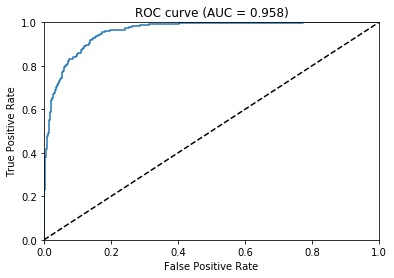

In [468]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

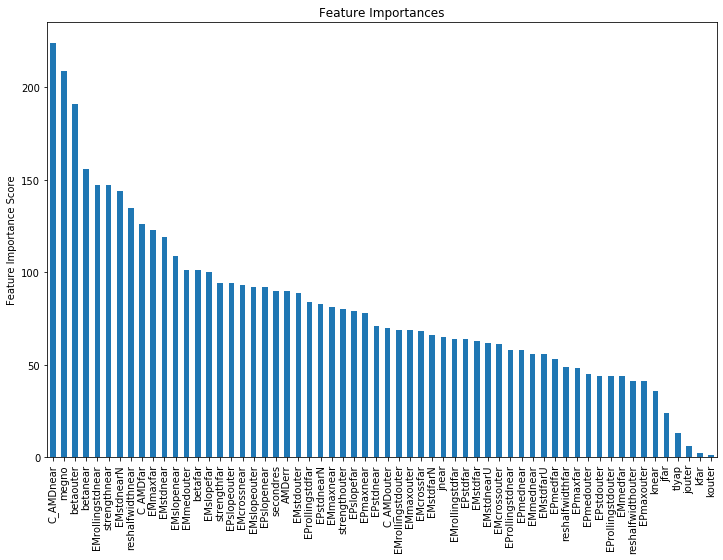

In [469]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# 9 trimmed features

Adding EMstdnearN (EMstd normalized by rehalfwidthnear) in addition to EMstdnear (normaalized to EMcrossnear) and removing reshalfwidthnear gives almost same performance.

Text(0.5, 1.0, 'ROC curve (AUC = 0.946)')

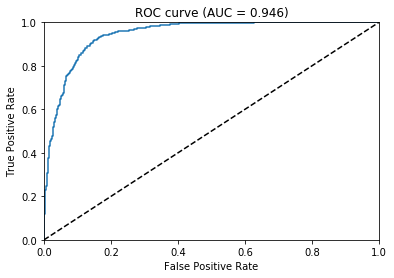

In [478]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

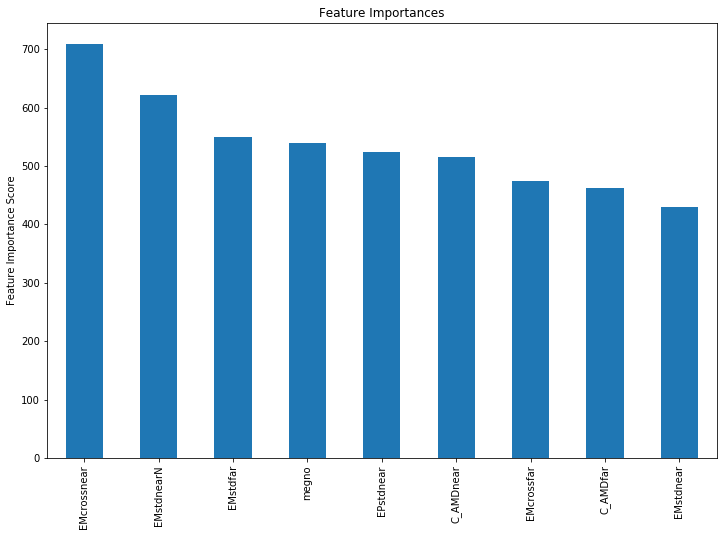

In [479]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# 11 trimmed features

Adding back strengthnear and secondres. Not sure if it's aa problem that strength isn't normalized to anything physical?

Text(0.5, 1.0, 'ROC curve (AUC = 0.948)')

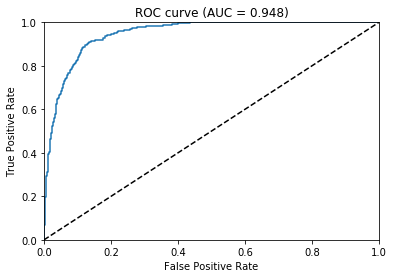

In [449]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

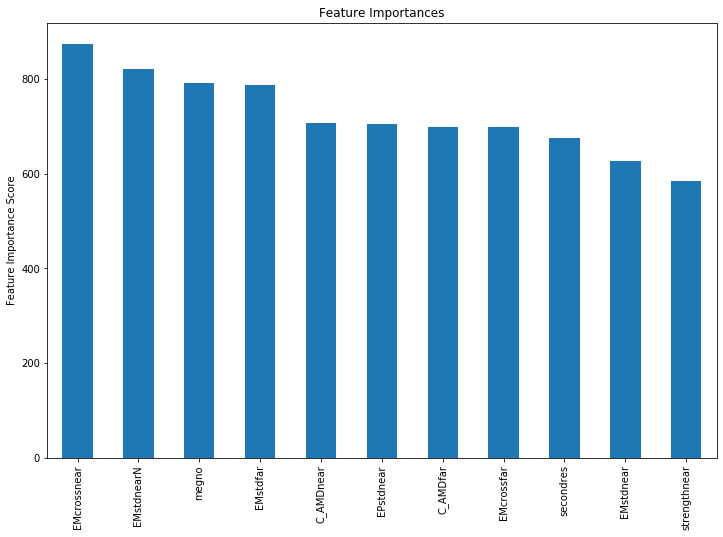

In [448]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [23]:
for i in range(0,len(fpr), 15):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(rocthresholds[i], fpr[i], tpr[i]))

Threshold 1.9999017715454102, FPR = 0.0, TPR = 0.0
Threshold 0.9860304594039917, FPR = 0.00411240575736806, TPR = 0.3844731977818854
Threshold 0.9591091871261597, FPR = 0.01028101439342015, TPR = 0.512014787430684
Threshold 0.9424808025360107, FPR = 0.018505825908156272, TPR = 0.5582255083179297
Threshold 0.9128478765487671, FPR = 0.025359835503769704, TPR = 0.6284658040665434
Threshold 0.8827143907546997, FPR = 0.033584647018505824, TPR = 0.6691312384473198
Threshold 0.8439748883247375, FPR = 0.03906785469499657, TPR = 0.7079482439926063
Threshold 0.8000836372375488, FPR = 0.04934886908841672, TPR = 0.7264325323475046
Threshold 0.7116411328315735, FPR = 0.06442769019876628, TPR = 0.7837338262476895
Threshold 0.6079264283180237, FPR = 0.07539410555174778, TPR = 0.8133086876155268
Threshold 0.5018351078033447, FPR = 0.08978752570253598, TPR = 0.8373382624768947
Threshold 0.4287303388118744, FPR = 0.10212474297464016, TPR = 0.8539741219963032
Threshold 0.3341927230358124, FPR = 0.1151473

In [100]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0025387408677488565, recall = 1.0, precision = 0.43876723438767234
Threshold 0.002793877152726054, recall = 0.9981515711645101, precision = 0.4433497536945813
Threshold 0.0033131123054772615, recall = 0.9981515711645101, precision = 0.4488778054862843
Threshold 0.0036996505223214626, recall = 0.9981515711645101, precision = 0.45454545454545453
Threshold 0.004002034198492765, recall = 0.9981515711645101, precision = 0.46035805626598464
Threshold 0.004368775989860296, recall = 0.9981515711645101, precision = 0.46632124352331605
Threshold 0.005086724646389484, recall = 0.9981515711645101, precision = 0.47244094488188976
Threshold 0.005759655963629484, recall = 0.9963031423290203, precision = 0.4778368794326241
Threshold 0.0063275182619690895, recall = 0.9944547134935305, precision = 0.4833782569631626
Threshold 0.006997937336564064, recall = 0.9944547134935305, precision = 0.4899817850637523
Threshold 0.007695464417338371, recall = 0.9944547134935305, precision = 0.49676823638

In [55]:
i=400
PRthreshold = PRthresholds[i]
rec = recall[i]
prec = precision[i]
print(PRthreshold, rec, prec)

0.06322314 0.9704251386321626 0.6302521008403361


In [86]:
trainX, trainy, testX, testy = train_test_split(trainingdatafolder, features, filter=False)
preds = model.predict_proba(testX)[:,1]

In [87]:
predy = (preds >= PRthreshold)

In [88]:
predlabels[:10]

array([False, False, False, False, False, False, False, False,  True,
        True])

In [89]:
testy[:10]

7999     True
8000    False
8001    False
8002    False
8003     True
8004    False
8005    False
8006     True
8007    False
8008    False
Name: Stable, dtype: bool

In [120]:
np.linspace(0,1,N)

array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

In [126]:
predy = (preds >= 0)
tn, fp, fn, tp = confusion_matrix(testy, predy).ravel()
tn, fp, fn, tp

(0, 1459, 0, 541)

In [128]:
npv[np.isnan(npv)] = 1

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

N=1000
npv, tnr = np.zeros(N), np.zeros(N)
ppv, tpr = np.zeros(N), np.zeros(N)
for i, thresh in enumerate(np.linspace(0, 1, N)):
    predy = (preds >= thresh)
    tn, fp, fn, tp = confusion_matrix(testy, predy).ravel()
    ppv[i] = tp/(tp+fp)
    tpr[i] = tp/(tp+fn)
    npv[i] = tn/(tn+fn)
    tnr[i] = tn/(tn+fp)
    
# When thresh is 0 or 1, we don't predict any of one class, so ppv and npv can be nan (conditioned on predicted pos or neg)
ppv[np.isnan(ppv)] = 1
npv[np.isnan(npv)] = 1
#tpr[np.isnan(tpr)] = 1
#tnr[np.isnan(tnr)] = 1

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [91]:
pp = tp+fp
pp

833

In [92]:
prec = tp/pp
prec

0.6302521008403361

In [93]:
p = tp+fn
rec = tp/p
rec

0.9704251386321626

In [116]:
for i in range(0,len(rec), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], rec[i], prec[i]))

Threshold 0.0025387408677488565, recall = 1.0, precision = 0.43876723438767234
Threshold 0.002793877152726054, recall = 0.9981515711645101, precision = 0.4433497536945813
Threshold 0.0033131123054772615, recall = 0.9981515711645101, precision = 0.4488778054862843
Threshold 0.0036996505223214626, recall = 0.9981515711645101, precision = 0.45454545454545453
Threshold 0.004002034198492765, recall = 0.9981515711645101, precision = 0.46035805626598464
Threshold 0.004368775989860296, recall = 0.9981515711645101, precision = 0.46632124352331605
Threshold 0.005086724646389484, recall = 0.9981515711645101, precision = 0.47244094488188976
Threshold 0.005759655963629484, recall = 0.9963031423290203, precision = 0.4778368794326241
Threshold 0.0063275182619690895, recall = 0.9944547134935305, precision = 0.4833782569631626
Threshold 0.006997937336564064, recall = 0.9944547134935305, precision = 0.4899817850637523
Threshold 0.007695464417338371, recall = 0.9944547134935305, precision = 0.49676823638

IndexError: index 1245 is out of bounds for axis 0 with size 1232

In [118]:
for i in range(0,len(rec), 15):
    print("Threshold {0}, tnr = {1}, npv = {2}".format(PRthresholds[i], tnr[i], npv[i]))

Threshold 0.0025387408677488565, tnr = 0.5257025359835503, npv = 1.0
Threshold 0.002793877152726054, tnr = 0.5352981494174092, npv = 0.9987212276214834
Threshold 0.0033131123054772615, tnr = 0.5455791638108294, npv = 0.998745294855709
Threshold 0.0036996505223214626, tnr = 0.5558601782042495, npv = 0.9987684729064039
Threshold 0.004002034198492765, tnr = 0.5661411925976696, npv = 0.9987908101571947
Threshold 0.004368775989860296, tnr = 0.5764222069910898, npv = 0.998812351543943
Threshold 0.005086724646389484, tnr = 0.5867032213845099, npv = 0.9988331388564761
Threshold 0.005759655963629484, tnr = 0.5962988348183688, npv = 0.9977064220183486
Threshold 0.0063275182619690895, tnr = 0.6058944482522276, npv = 0.9966178128523112
Threshold 0.006997937336564064, tnr = 0.6161754626456477, npv = 0.9966740576496674
Threshold 0.007695464417338371, tnr = 0.6264564770390678, npv = 0.9967284623773174
Threshold 0.008507847785949707, tnr = 0.636737491432488, npv = 0.9967811158798283
Threshold 0.009628

IndexError: index 1245 is out of bounds for axis 0 with size 1232

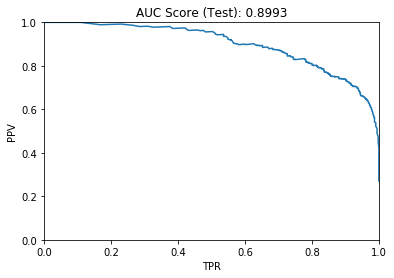

In [134]:
pr_auc = auc(tpr, ppv)
fig, ax = plt.subplots()
ax.plot(tpr, ppv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TPR')
ax.set_ylabel('PPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

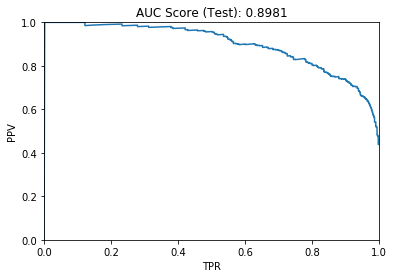

In [107]:
pr_auc = auc(tpr, ppv)
fig, ax = plt.subplots()
ax.plot(tpr, ppv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TPR')
ax.set_ylabel('PPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

In [115]:
tpr.shape

(1999,)

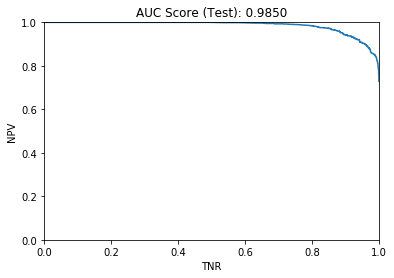

In [135]:
nauc = auc(tnr, npv)
fig, ax = plt.subplots()
ax.plot(tnr, npv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TNR')
ax.set_ylabel('NPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(nauc))
plt.show()

(0, 216.70000000000002)

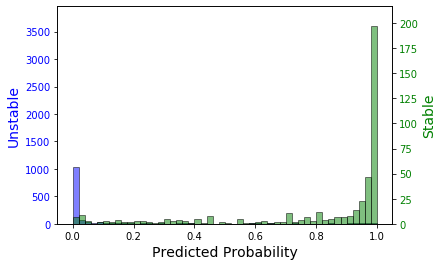

In [470]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

# 9 feat

(0, 114.4)

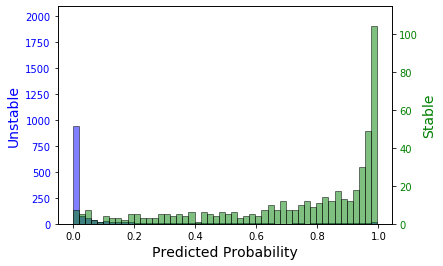

In [480]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

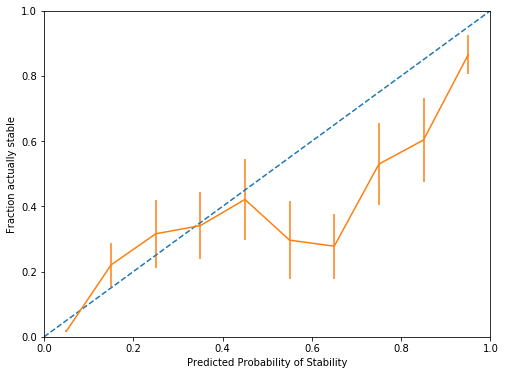

In [471]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

# 9 feat

Text(0, 0.5, 'Fraction actually stable')

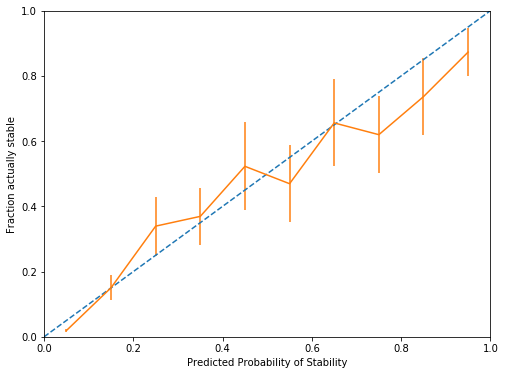

In [482]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

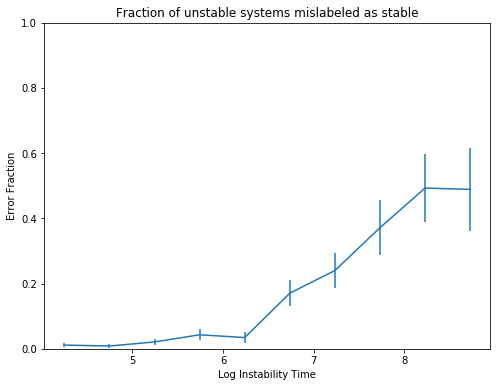

In [472]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

# 9 feat

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

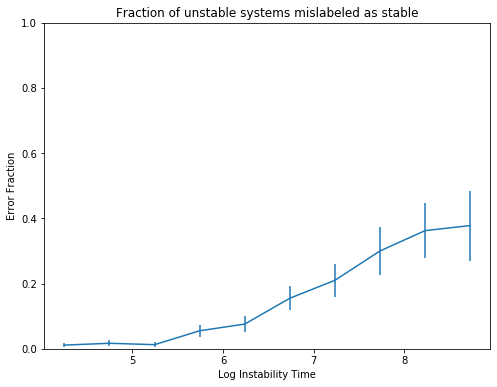

In [484]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

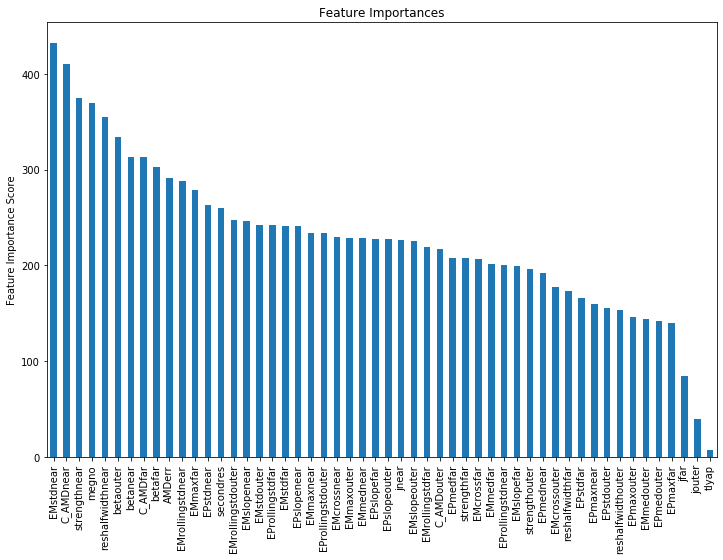

In [13]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'betanear', 'jnear', 'strengthnear', 'strengthouter', 'reshalfwidthnear', 'betafar', 'jfar', 'strengthfar', 'reshalfwidthfar', 'betaouter', 'secondres', 'reshalfwidthouter', 'jouter']

tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear']

ROC AUC = 0.958

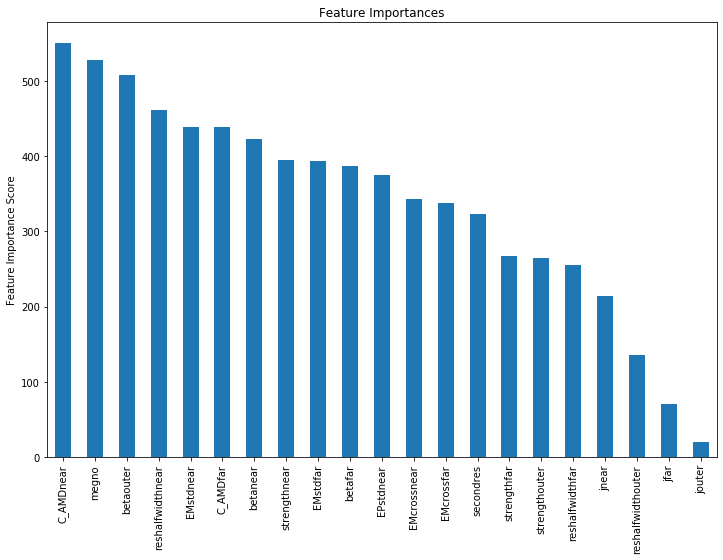

In [165]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'betanear', 'strengthnear', 'reshalfwidthnear', 'betafar',
                   'strengthfar', 'reshalfwidthfar', 'secondres']

tseriesshort = ['EMstdnear', 'EMstdfar', 'EPstdnear']

i.e. remove all outer features and j

ROC AUC = 0.951

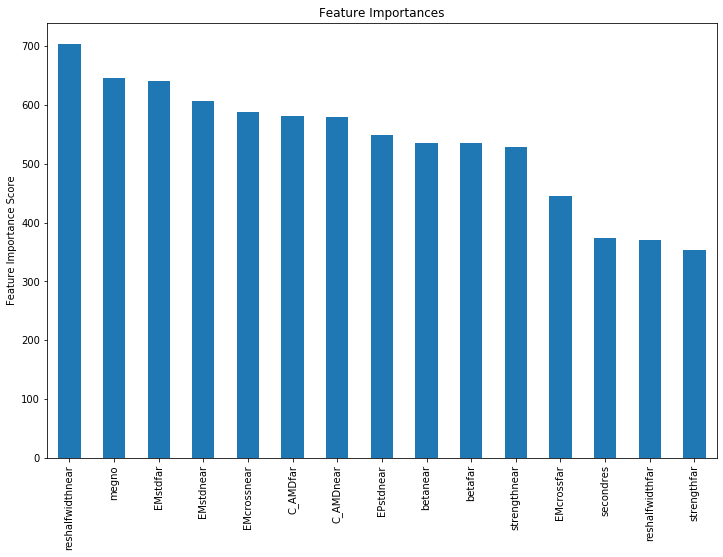

In [173]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams

ROC AUC = 0.951

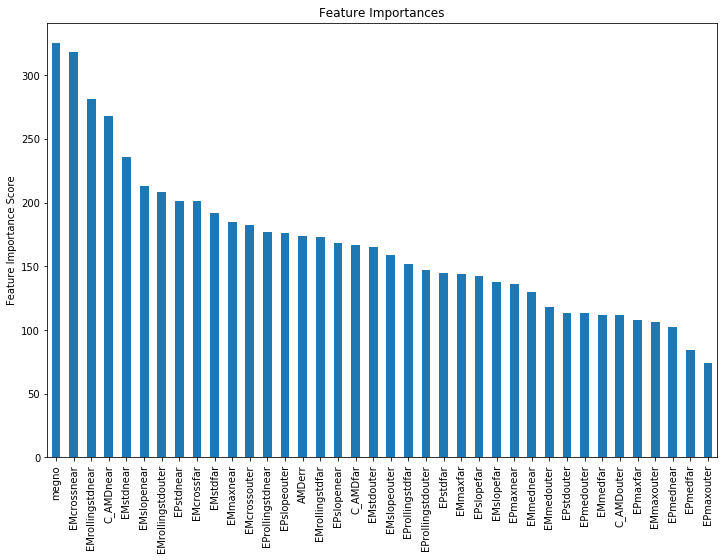

In [119]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No respRarams tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear', 'EMrollingstdnear', 'EProllingstdnear']

ROC AUC = 0.946

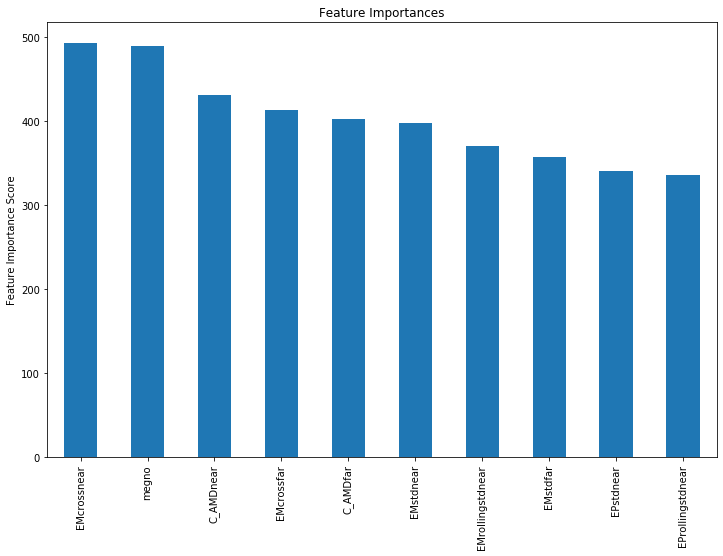

In [146]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

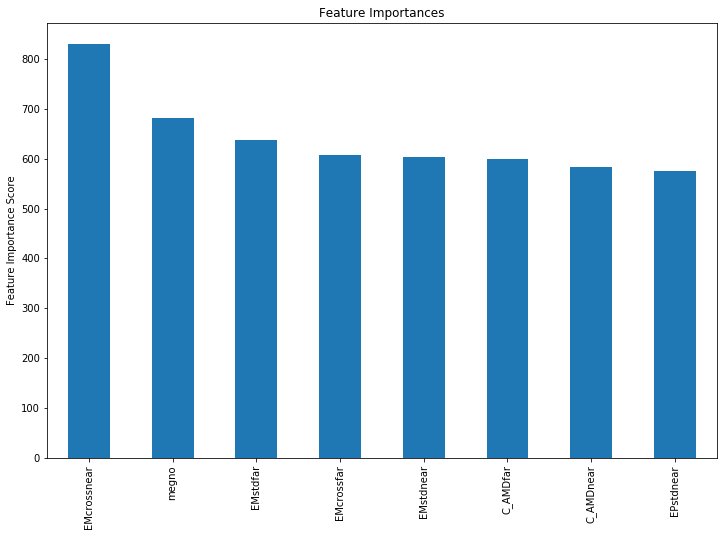

In [154]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

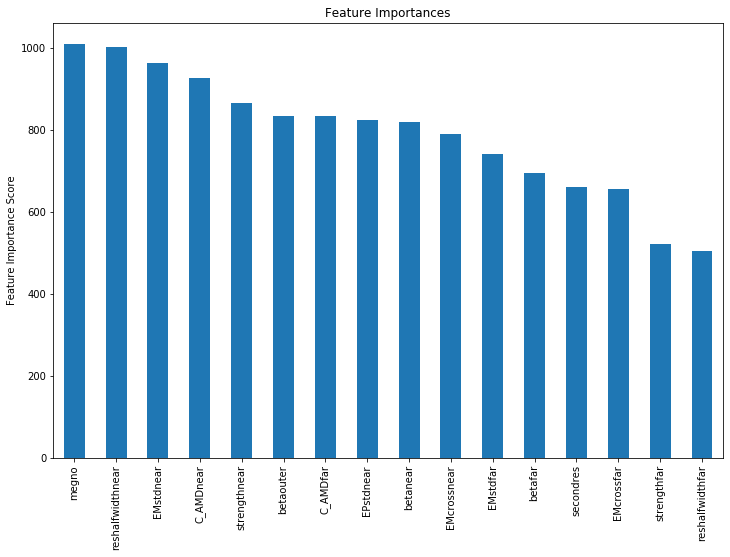

In [179]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams, tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EPstdnear']

ROC AUC = 0.942

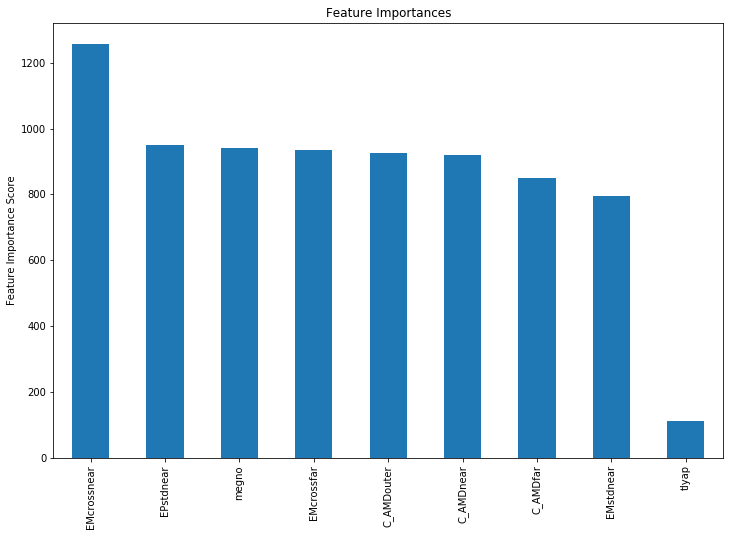

In [101]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'EMstdnear', 'EMstdfar', 'EMstdouter', 'EPstdnear', 'EPstdfar', 'EPstdouter', 'EMrollingstdnear', 'EProllingstdnear'] 

ROC AUC = 0.950

so as good as full restseries (which got 0.951)

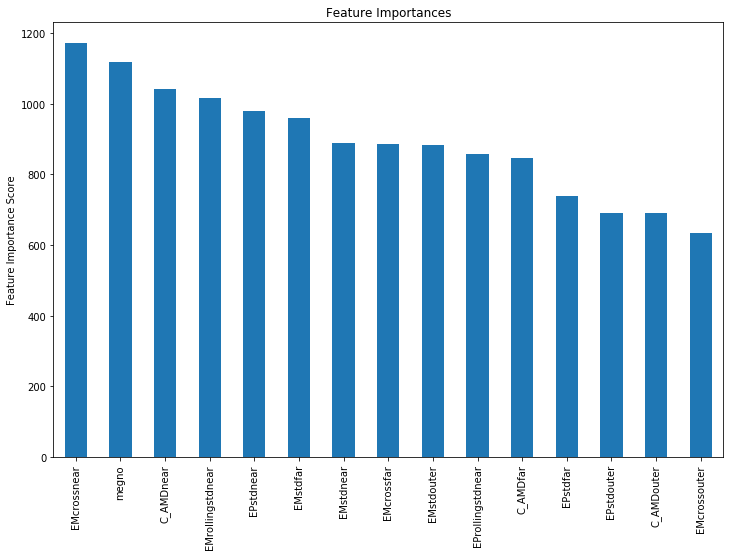

In [107]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams tseriesshort = ['EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear', 'EPstdfar', 'EMrollingstdnear', 'EProllingstdnear']

i.e. no outer features

ROC AUC = 0.948

So outer features don't help much

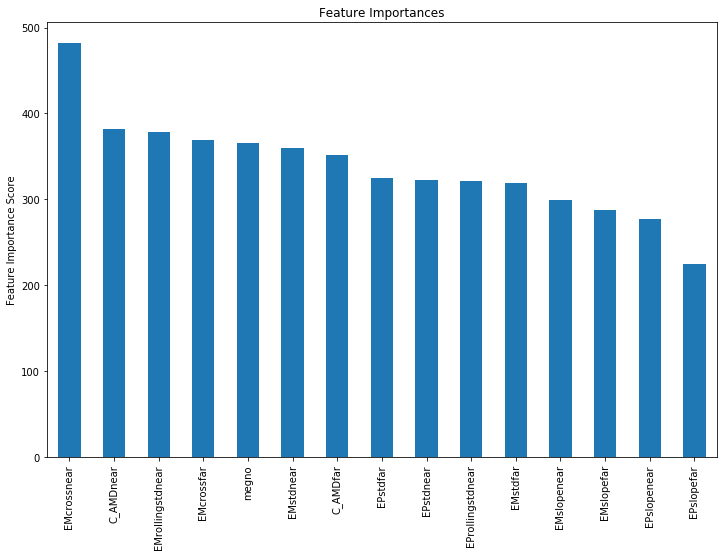

In [138]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# No resparams tseriesshort = ['EMslopenear', 'EMslopefar', 'EPslopenear', 'EPslopefar', 'EMcrossnear', 'EMcrossfar', 'EMstdnear', 'EMstdfar', 'EPstdnear', 'EPstdfar', 'EMrollingstdnear', 'EProllingstdnear']
i.e. adding slope features

ROC AUC = 0.948

so didn't help


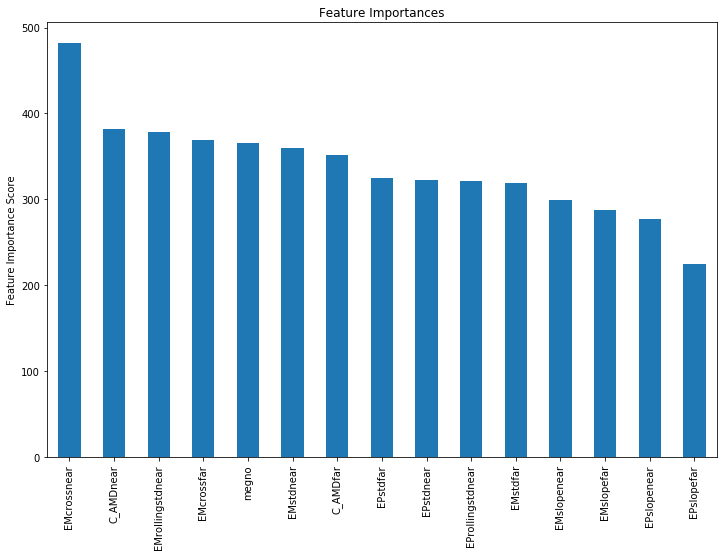

In [139]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# We care about probability it is unstable when we predict unstable. Look at these errors specifically